Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

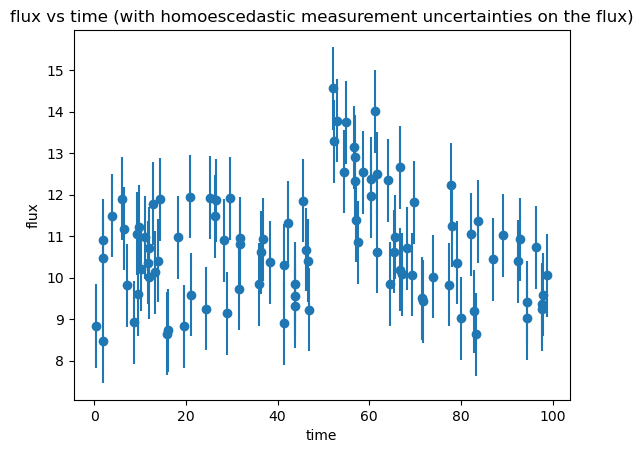

In [4]:
data = np.load('transient.npy')
plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o")
plt.xlabel('time')
plt.ylabel('flux')
plt.title('flux vs time (with homoescedastic measurement uncertainties on the flux)')
plt.show()

One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [5]:
t_0 =  50
b = 10
A = 14
alfa = 0.5

init_par = np.array([t_0, b, A, alfa])

In [6]:
def burst(par, t):
    t_0, b, A, alfa = par
    if (t < t_0): return b
    else: return b + A * np.exp(-alfa * (t - t_0))

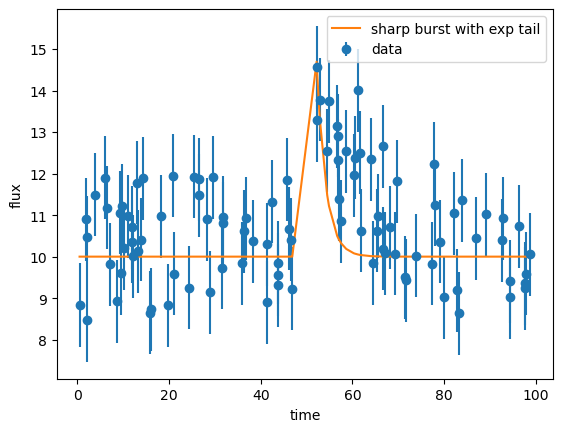

In [7]:
plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o", label = 'data')
y_time =[burst(init_par, d) for d in data [:, 0]]
plt.plot(data[:, 0], y_time, label = 'sharp burst with exp tail')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

The likelihood function L is defined as produttoria di f(xi, beta) dove f è la pdf di un punto x, con media mu e dev std sigma. If we assume the data to be an independent and identiccaly ditributed samples: then the residuals are from a normal distribution and L is:
$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

In [36]:
def log_llh(par, data):
    x, y, sigma_y = data.T
    y_model = [burst(par, xi) for xi in x]
    log_llh = -0.5 * np.sum((y - y_model)**2 / sigma_y ** 2)
    if np.isnan(log_llh): print('found nan in log_llh')
    return log_llh

t_0min, t_0max = 0, 100
bmin, bmax = 0,50
Amin, Amax = 0,50
alphamin, alphamax = np.exp(-5), np.exp(5)

#we have a uniform distribution on A, b, t0 and 1/alpha
#if we go to a log prior we have a constant in A, b and t_0 which we put to zero
#and a log(alpha)
def log_prior (parameters):
    t_0, b, A, alpha = parameters
    if t_0min < t_0 < t_0max and bmin < b < bmax and Amin < A < Amax and alphamin < alpha < alphamax:
        bah =  -np.log(alpha)
    else:        
        bah = -np.inf #we return -inf if one of our parameters ends outside the range we fixed
   
    if np.isnan(bah): print('found nan in log_prior')    
    return bah

def log_posterior(par, data):
    uno = log_llh(par, data)
    due = log_prior(par)
    result =  uno + due
    #if uno == np.inf and due == -np.inf: result = 0
    if np.isnan(result): print('found nan in log_posterior')
    return result

Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).


In [52]:
n_parameters = 4 #number of parameters, which are b, A, t_0, alfa
nwalkers = 20  # number of MCMC walkers
nsteps = int(1e4)  # number of MCMC steps to take **for each walker**
starting_guesses = np.empty([nwalkers, n_parameters])

#for i in range(nwalkers): #->doesn't converge, we have to change it
#    starting_guesses[i][0] = np.random.uniform(0, 100)
#    starting_guesses[i][1] = np.random.uniform(0, 50)
#    starting_guesses[i][2] = np.random.uniform(0, 50)
#    starting_guesses[i][3] = np.exp(np.random.uniform(-5, 5))

starting_guesses = init_par + 1e-1* np.random.randn(nwalkers, n_parameters) #-> it works like this

In [53]:
sampler = emcee.EnsembleSampler(nwalkers, n_parameters, log_posterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)

print('done')

done


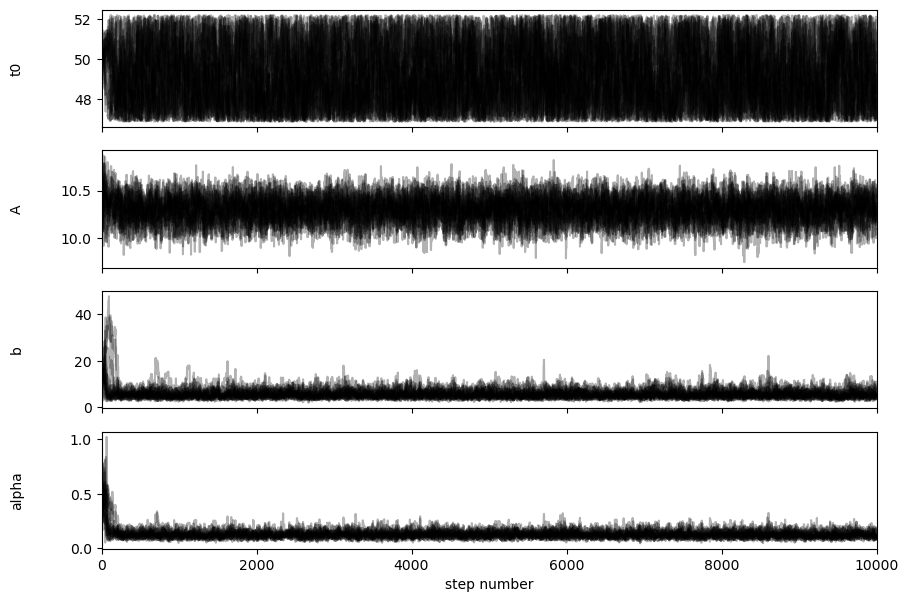

In [54]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t0","A","b","alpha"]
for i in range(n_parameters):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [56]:
import corner

C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\base.py:265: UserWarning: More chains (10000) than draws (20). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


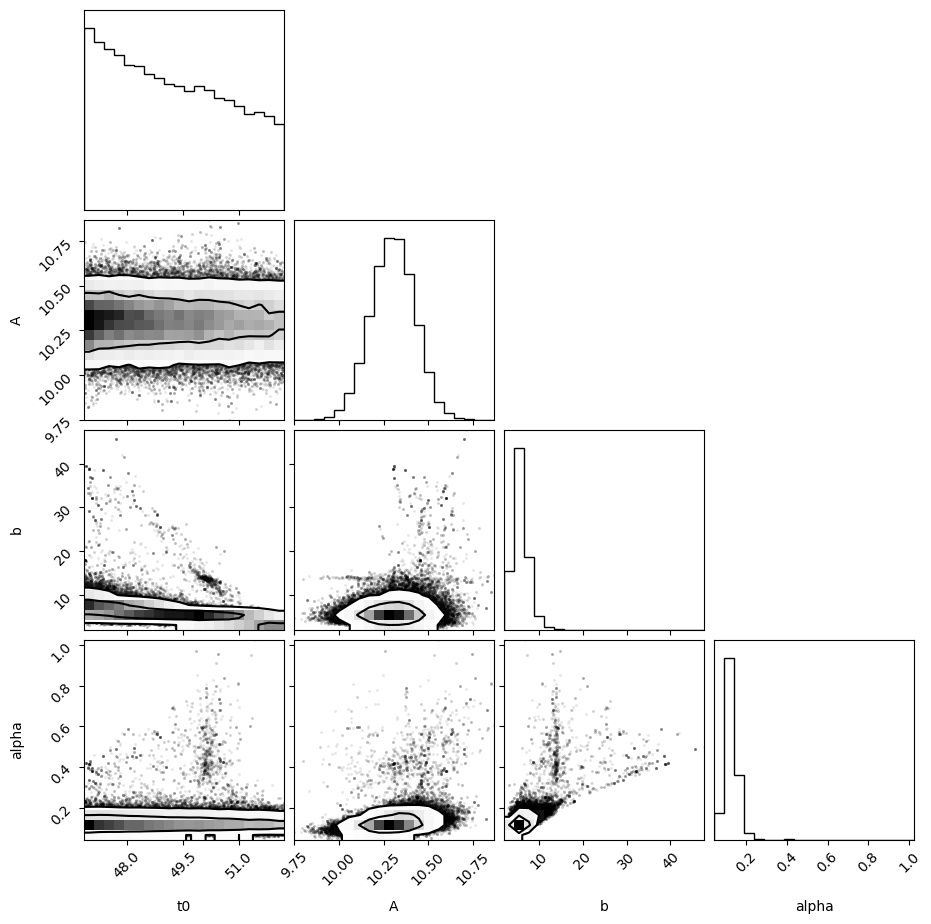

In [57]:
fig = corner.corner(
    samples, labels=labels, levels=[0.68,0.95]
);

If we instead thin out our samples:

In [58]:
tau = sampler.get_autocorr_time()
print(tau)

[71.98332463 59.68121088 76.34897628 82.32597994]


In [59]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)
#2180 lines, each one is a posterior sample and corresponds to a given model (meaning with the 4 parameters). 
#we can choose one i.e. by picking the one which maximises the posterior

(2360, 4)


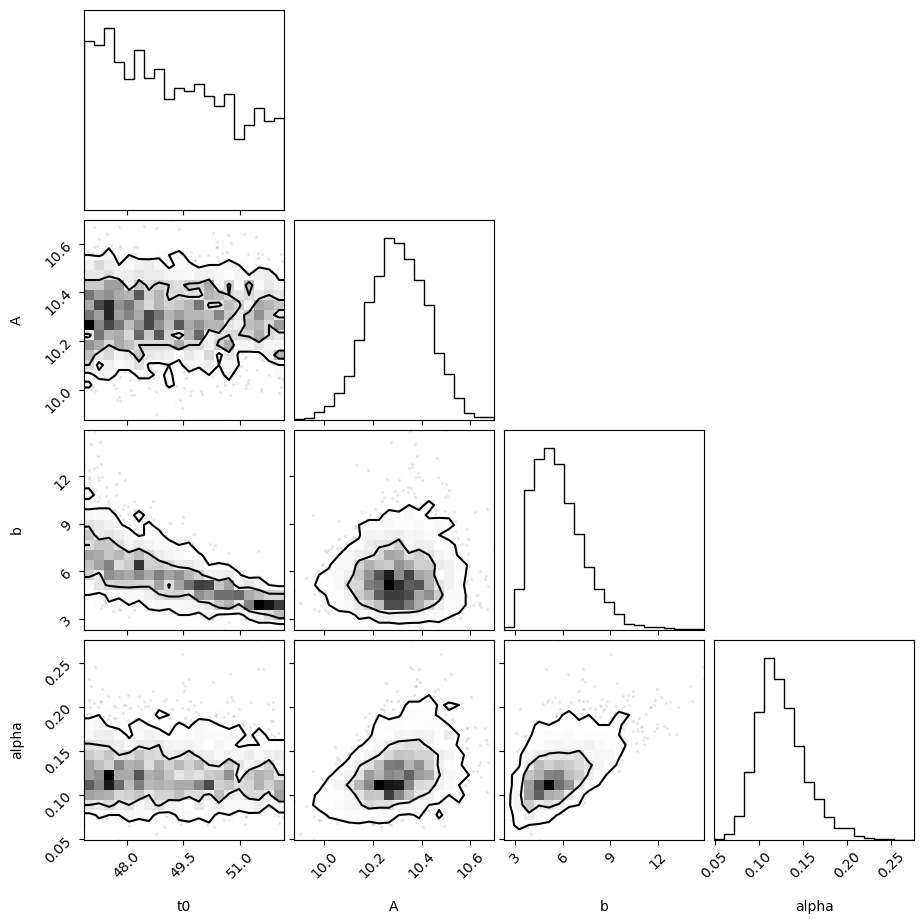

In [60]:
fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68,0.95]
);